In [1]:
# Importação das bibliotecas
import requests 
from bs4 import BeautifulSoup 
import pandas as pd 
import re
import locale
import time
import os
import matplotlib.pyplot as plt

In [2]:
#Define a região do locale como Brasil para formatação correta da Moeda e acentuação.
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

In [3]:
# url das informações dos títulos.
url_fonte = 'http://www.tesouro.fazenda.gov.br/tesouro-direto-precos-e-taxas-dos-titulos'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'}

In [4]:
# Conectando na página
con = requests.get(url_fonte, headers=headers)

In [5]:
# Status da Conexão. Status 200 conexão Ok.
#https://www.w3.org/Protocols/HTTP/1.1/draft-ietf-http-v11-spec-01#Status-Codes
con.status_code

200

In [6]:
# Cria objeto BeautifulSoup com o conteúdo html da página
soup = BeautifulSoup(con.content, "html.parser")

#soup.prettify()

In [7]:
#Extraindo a tabela de Resgaste de Titulos
tabela_historico = soup.find('table', {'class': 'tabelaPrecoseTaxas sanfonado'}) 

#tabela_historico

In [8]:
# Extrai o conteúdo do corpo da  tabela.
body_tabela = tabela_historico.find('tbody')

#body_tabela

In [9]:
# Extrai as linhas do cabeçalho da tabela.
linhas_cabecalho_tabela = body_tabela.find_all('th')
cabecalho_tabela_tratada = []

for linha in linhas_cabecalho_tabela:
    cabecalho_tabela_tratada.append(linha.text.strip())

#cabecalho_tabela_tratada

In [10]:
# Extrai as linhas do restando corpo da tabela com os valores e descrições
linhas_tabela = body_tabela.find_all(class_='camposTesouroDireto')
linhas_tabela_tratada = []

for linha in linhas_tabela:
    colunas=linha.find_all('td')
    colunas=[x.text.strip() for x in colunas]
    linhas_tabela_tratada.append(colunas)
    
#linhas_tabela_tratada

In [11]:
#Cria um dataframe com as linhas do corpo da tabela.
df_titulos = pd.DataFrame(linhas_tabela_tratada)

#df_titulos

In [12]:
#Adiciona o cabeçalho da tabela no dataframe de titulos criado.
df_titulos.columns = cabecalho_tabela_tratada

In [13]:
#Exibe as primeiras linha do dataframe
df_titulos.head()

,Título,Vencimento,Taxa de Rendimento (% a.a.),Preço Unitário
0,Tesouro IPCA+ 2019,15/05/2019,"-0,04","R$3.206,71"
1,Tesouro IPCA+ 2024,15/08/2024,"4,30","R$2.562,99"
2,Tesouro IPCA+ 2035,15/05/2035,"4,66","R$1.544,99"
3,Tesouro IPCA+ 2045,15/05/2045,"4,66","R$981,00"
4,Tesouro IPCA+ com Juros Semestrais 2020,15/08/2020,"2,99","R$3.359,81"


In [14]:
#Verifica os tipos de dados antes as conversões.
df_titulos.dtypes

Título                         object
Vencimento                     object
Taxa de Rendimento (% a.a.)    object
Preço Unitário                 object
dtype: object

In [15]:
### Define algumas funções para ajudar no tratamento dos dados.

# Define a função que Remove Simbolo de moeda
def removeSimboloMoeda(string):
    return string.strip().replace('R$','')


#Define a função que Inverte o separador decimal.
def inverteSeparadorDecimal(string):
    string = str(string).replace(',','v')
    string = string.replace('.',',')
    string = string.replace('v','.')
    
    return string

#Define a função que Converte um objeto para float
def objToFloat(obj):
    return  locale.atof(removeSimboloMoeda(obj))


#Define a função que retorna os segundos no formato hh:mm:ss
def formata_segundos_hhmmss(segundos):
    return time.strftime('%H:%M:%S', time.gmtime(segundos))

#Define a função que retorna data atual do sistema.
def get_data_atual():
    return time.strftime("%d/%m/%Y")

#Define a função que retorna a data e hora atual do sistema.
def get_data_hora_atual():
    return time.strftime("%d/%m/%Y %H:%M:%S")

# Define a Função para Cria um diretório, se não existir
def cria_diretorio(path, recursivo=False):
    if not os.path.exists(path):
        if recursivo:
            os.makedirs(path)
        else:
            os.mkdir(path)

In [16]:
# Trata os tipos de dados das colunas

#Converte Coluna "Vencimento" para data
df_titulos['Vencimento'] = pd.to_datetime(df_titulos['Vencimento'])

# Converte Coluna "Taxa de Rendimento (% a.a.)" para Float
df_titulos['Taxa de Rendimento (% a.a.)'] = df_titulos['Taxa de Rendimento (% a.a.)'].apply(objToFloat)

# Converte Coluna "Preço Unitário" para Float
df_titulos['Preço Unitário'] = df_titulos['Preço Unitário'].apply(objToFloat)

# Adiciona a coluna "Data Hora Registro" que informa a data e hora da coleta dos dados.
df_titulos['Data Hora Registro'] =  pd.to_datetime( get_data_hora_atual())

In [17]:
#Verifica os tipos de dados após as conversões.
df_titulos.dtypes

Título                                 object
Vencimento                     datetime64[ns]
Taxa de Rendimento (% a.a.)           float64
Preço Unitário                        float64
Data Hora Registro             datetime64[ns]
dtype: object

In [18]:
# Visualizando o dataframe após as conversões.
df_titulos.head()

,Título,Vencimento,Taxa de Rendimento (% a.a.),Preço Unitário,Data Hora Registro
0,Tesouro IPCA+ 2019,2019-05-15,-0.04,3206.71,2019-12-04 15:22:41
1,Tesouro IPCA+ 2024,2024-08-15,4.30,2562.99,2019-12-04 15:22:41
2,Tesouro IPCA+ 2035,2035-05-15,4.66,1544.99,2019-12-04 15:22:41
3,Tesouro IPCA+ 2045,2045-05-15,4.66,981.00,2019-12-04 15:22:41
4,Tesouro IPCA+ com Juros Semestrais 2020,2020-08-15,2.99,3359.81,2019-12-04 15:22:41


In [19]:
# Define a Titulo como indice do dataframe.
df_titulos.set_index('Título')

,Vencimento,Taxa de Rendimento (% a.a.),Preço Unitário,Data Hora Registro
Título,,,,
Tesouro IPCA+ 2019,2019-05-15,-0.04,3206.71,2019-12-04 15:22:41
Tesouro IPCA+ 2024,2024-08-15,4.30,2562.99,2019-12-04 15:22:41
Tesouro IPCA+ 2035,2035-05-15,4.66,1544.99,2019-12-04 15:22:41
Tesouro IPCA+ 2045,2045-05-15,4.66,981.00,2019-12-04 15:22:41
Tesouro IPCA+ com Juros Semestrais 2020,2020-08-15,2.99,3359.81,2019-12-04 15:22:41
Tesouro IPCA+ com Juros Semestrais 2024,2024-08-15,4.23,3501.41,2019-12-04 15:22:41
Tesouro IPCA+ com Juros Semestrais 2026,2026-08-15,4.33,3564.48,2019-12-04 15:22:41
Tesouro IPCA+ com Juros Semestrais 2035,2035-05-15,4.57,3797.65,2019-12-04 15:22:41
Tesouro IPCA+ com Juros Semestrais 2045,2045-05-15,4.66,3924.39,2019-12-04 15:22:41


In [20]:
# Dados planilha que contém a carteira de títulos que serão acompanhados.
path_planilha_carteira = './base_dados/carteira_titulos_tesouro.xlsx'
nome_aba_carteira = 'MinhaCarteiraTitulosTesouro'

In [21]:
# Importa os títulos da carteiraque serão acompanhados.
df_carteira = pd.read_excel(path_planilha_carteira, sheet_name=nome_aba_carteira,header=1, usecols=[1,2,4,5,6,7,8,9] )
df_carteira

,Título,Data de vencimento,Preço para investimento (R$),Quantidade Compra,Data Compra,Valor Investido,Tipo,% Rentabilidade (a.a)
0,Tesouro Selic 2023,2023-03-01,9803.59,0.06,2018-11-12,587.9200,SELIC,0.0005
1,Tesouro Selic 2023,2023-03-01,9803.59,0.37,2018-11-13,3627.3283,SELIC,0.0005
2,Tesouro Selic 2023,2023-03-01,9803.59,0.08,2018-11-29,786.2200,SELIC,0.0005
3,Tesouro IPCA+ 2035,2035-05-15,1522.04,1.19,2019-01-15,1811.2200,IPCA,0.0459
4,Tesouro Selic 2023,2023-03-01,9903.19,0.19,2019-01-15,1881.6000,SELIC,0.0001
5,Tesouro IPCA+ 2035,2035-05-15,1567.14,2.32,2019-02-15,3635.7600,IPCA,0.0445
6,Tesouro Selic 2023,2035-05-15,9951.53,0.35,2019-02-15,3483.0300,SELIC,0.0002
7,Tesouro IPCA+ 2035,2035-05-15,1565.18,3.81,2019-02-18,5963.3300,IPCA,0.0446


In [22]:
# Faz o join dos dataframes
df_merge = pd.merge(df_carteira, df_titulos, on='Título', how='left')
#df_merge

In [23]:
#Remove as colunas que não serão usadas
df_merge = df_merge.drop(columns = ['Tipo','Data de vencimento', 'Data Hora Registro', 'Taxa de Rendimento (% a.a.)','% Rentabilidade (a.a)'])

In [24]:
# Renomeia algumas colunas do dataframe.
df_merge.rename(index=str, columns={'Preço Unitário': 'Preço Resgate', 'Preço para investimento (R$)': 'Preço Compra' }, inplace=True)

In [25]:
#Calcula a diferença entre o valor atual e valor pago
df_merge['Preço Resgate menos Compra'] = df_merge['Preço Resgate'] - df_merge['Preço Compra']
df_merge

,Título,Preço Compra,Quantidade Compra,Data Compra,Valor Investido,Vencimento,Preço Resgate,Preço Resgate menos Compra
0,Tesouro Selic 2023,9803.59,0.06,2018-11-12,587.9200,2023-01-03,10049.38,245.79
1,Tesouro Selic 2023,9803.59,0.37,2018-11-13,3627.3283,2023-01-03,10049.38,245.79
2,Tesouro Selic 2023,9803.59,0.08,2018-11-29,786.2200,2023-01-03,10049.38,245.79
3,Tesouro IPCA+ 2035,1522.04,1.19,2019-01-15,1811.2200,2035-05-15,1544.99,22.95
4,Tesouro Selic 2023,9903.19,0.19,2019-01-15,1881.6000,2023-01-03,10049.38,146.19
5,Tesouro IPCA+ 2035,1567.14,2.32,2019-02-15,3635.7600,2035-05-15,1544.99,-22.15
6,Tesouro Selic 2023,9951.53,0.35,2019-02-15,3483.0300,2023-01-03,10049.38,97.85
7,Tesouro IPCA+ 2035,1565.18,3.81,2019-02-18,5963.3300,2035-05-15,1544.99,-20.19


In [26]:
### Define algumas funções para ajudar nos cálculos

# Taxa do imposto de renda aplicado.
def getTaxaIRPF():
    return  22.5

#Calcula o rendimento bruto, ainda sem os descontos.
def calculaRendimentoBruto(precoResgate, quantidadeCompra, valoInvestido):
    return (precoResgate *  quantidadeCompra) - valoInvestido
  
# Calcula o valor IRPF que será descontado.
def calculaValorIRPF(rendimentoBruto, taxa_IRPF):
    return rendimentoBruto * taxa_IRPF

# Calcula o rendimento após o desconto do IRPF
def calculaRendimentoDescontadoIRPF(rendimentoBruto, valorIRPF):
    return rendimentoBruto - valorIRPF

# Calcula o % do redimento  após o desconto do IRPF
def calculaPercentualRendimentoDescontadoIRPF(rendimentoDescontadoIRPF, valorIvestido):
    return rendimentoDescontadoIRPF / valorIvestido

In [27]:
#Cria as colunas com os calculos de rendimentos
df_merge['Rendimento Bruto']  = df_merge.apply(lambda col: calculaRendimentoBruto(col['Preço Resgate'],col['Quantidade Compra'],col['Valor Investido']), axis=1)
df_merge['Valor IRPF (R$)'] = df_merge.apply(lambda col: calculaValorIRPF(col['Rendimento Bruto'],getTaxaIRPF()), axis=1)
df_merge['Rendimento descontado IRPF (R$)'] = df_merge.apply(lambda col: calculaRendimentoDescontadoIRPF(col['Rendimento Bruto'], col['Valor IRPF (R$)']), axis=1)
df_merge['Rendimento descontado IRPF %'] = df_merge.apply(lambda col: calculaPercentualRendimentoDescontadoIRPF(col['Rendimento descontado IRPF (R$)'] , col['Valor Investido']), axis=1)
df_merge

,Título,Preço Compra,Quantidade Compra,Data Compra,Valor Investido,Vencimento,Preço Resgate,Preço Resgate menos Compra,Rendimento Bruto,Valor IRPF (R$),Rendimento descontado IRPF (R$),Rendimento descontado IRPF %
0,Tesouro Selic 2023,9803.59,0.06,2018-11-12,587.9200,2023-01-03,10049.38,245.79,15.0428,338.46300,-323.42020,-0.550109
1,Tesouro Selic 2023,9803.59,0.37,2018-11-13,3627.3283,2023-01-03,10049.38,245.79,90.9423,2046.20175,-1955.25945,-0.539036
2,Tesouro Selic 2023,9803.59,0.08,2018-11-29,786.2200,2023-01-03,10049.38,245.79,17.7304,398.93400,-381.20360,-0.484856
3,Tesouro IPCA+ 2035,1522.04,1.19,2019-01-15,1811.2200,2035-05-15,1544.99,22.95,27.3181,614.65725,-587.33915,-0.324278
4,Tesouro Selic 2023,9903.19,0.19,2019-01-15,1881.6000,2023-01-03,10049.38,146.19,27.7822,625.09950,-597.31730,-0.317452
5,Tesouro IPCA+ 2035,1567.14,2.32,2019-02-15,3635.7600,2035-05-15,1544.99,-22.15,-51.3832,-1156.12200,1104.73880,0.303854
6,Tesouro Selic 2023,9951.53,0.35,2019-02-15,3483.0300,2023-01-03,10049.38,97.85,34.2530,770.69250,-736.43950,-0.211436
7,Tesouro IPCA+ 2035,1565.18,3.81,2019-02-18,5963.3300,2035-05-15,1544.99,-20.19,-76.9181,-1730.65725,1653.73915,0.277318


In [28]:
# Define o índice dataframe
df_merge.set_index('Título')

,Preço Compra,Quantidade Compra,Data Compra,Valor Investido,Vencimento,Preço Resgate,Preço Resgate menos Compra,Rendimento Bruto,Valor IRPF (R$),Rendimento descontado IRPF (R$),Rendimento descontado IRPF %
Título,,,,,,,,,,,
Tesouro Selic 2023,9803.59,0.06,2018-11-12,587.9200,2023-01-03,10049.38,245.79,15.0428,338.46300,-323.42020,-0.550109
Tesouro Selic 2023,9803.59,0.37,2018-11-13,3627.3283,2023-01-03,10049.38,245.79,90.9423,2046.20175,-1955.25945,-0.539036
Tesouro Selic 2023,9803.59,0.08,2018-11-29,786.2200,2023-01-03,10049.38,245.79,17.7304,398.93400,-381.20360,-0.484856
Tesouro IPCA+ 2035,1522.04,1.19,2019-01-15,1811.2200,2035-05-15,1544.99,22.95,27.3181,614.65725,-587.33915,-0.324278
Tesouro Selic 2023,9903.19,0.19,2019-01-15,1881.6000,2023-01-03,10049.38,146.19,27.7822,625.09950,-597.31730,-0.317452
Tesouro IPCA+ 2035,1567.14,2.32,2019-02-15,3635.7600,2035-05-15,1544.99,-22.15,-51.3832,-1156.12200,1104.73880,0.303854
Tesouro Selic 2023,9951.53,0.35,2019-02-15,3483.0300,2023-01-03,10049.38,97.85,34.2530,770.69250,-736.43950,-0.211436
Tesouro IPCA+ 2035,1565.18,3.81,2019-02-18,5963.3300,2035-05-15,1544.99,-20.19,-76.9181,-1730.65725,1653.73915,0.277318


In [29]:
# Seleciona somente o Título de interesse.
df_final = df_merge.loc[df_merge['Título'] == 'Tesouro IPCA+ 2035']
df_final.set_index(['Título', 'Data Compra'])


Preço Compra  Quantidade Compra  \
Título             Data Compra                                    
Tesouro IPCA+ 2035 2019-01-15        1522.04               1.19   
                   2019-02-15        1567.14               2.32   
                   2019-02-18        1565.18               3.81   

                                Valor Investido Vencimento  Preço Resgate  \
Título             Data Compra                                              
Tesouro IPCA+ 2035 2019-01-15           1811.22 2035-05-15        1544.99   
                   2019-02-15           3635.76 2035-05-15        1544.99   
                   2019-02-18           5963.33 2035-05-15        1544.99   

                                Preço Resgate menos Compra  Rendimento Bruto  \
Título             Data Compra                                                 
Tesouro IPCA+ 2035 2019-01-15                        22.95           27.3181   
                   2019-02-15                       -22.15          -51.3832   
                   2019-02-18                       -20.19          -76.9181   

                                Valor IRPF (R$)  \
Título             Data Compra                    
Tesouro IPCA+ 2035 2019-01-15         614.65725   
                   2019-02-15       -1156.12200   
                   2019-02-18       -1730.65725   

                                Rendimento descontado IRPF (R$)  \
Título             Data Compra                                    
Tesouro IPCA+ 2035 2019-01-15                        -587.33915   
                   2019-02-15                        1104.73880   
                   2019-02-18                        1653.73915   

                                Rendimento descontado IRPF %  
Título             Data Compra                                
Tesouro IPCA+ 2035 2019-01-15                      -0.324278  
                   2019-02-15                       0.303854  
                   2019-02-18                       0.277318

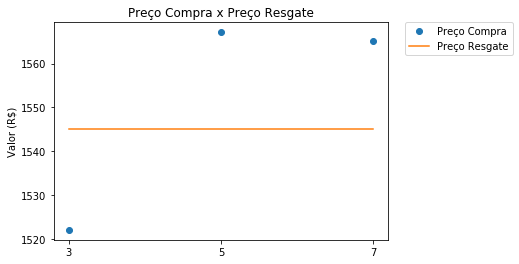

In [30]:
# Visualiza a comparação dos valores de Compra e Resgate (Venda)
plt.title('Preço Compra x Preço Resgate')
plt.plot(df_final['Preço Compra'], 'o')
plt.plot(df_final['Preço Resgate'], )
plt.ylabel('Valor (R$)')
#plt.xlabel('Qtd')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [31]:
# Define os limiares para disparar o envio da mensagem,
taxaRendimento = 1.0
valorDiferenca = 1.0

In [32]:
# Seleciona os Títulos onde os valores atingiram os limiare definidos.
df_selecao_final = df_final[ (df_final['Rendimento descontado IRPF %'] > taxaRendimento) & ( df_final['Preço Resgate menos Compra'] > valorDiferenca) ]
df_selecao_final

,Título,Preço Compra,Quantidade Compra,Data Compra,Valor Investido,Vencimento,Preço Resgate,Preço Resgate menos Compra,Rendimento Bruto,Valor IRPF (R$),Rendimento descontado IRPF (R$),Rendimento descontado IRPF %


In [33]:
# Formata a mensagem que será enviada.
lista_msgs = []

for index, row  in df_selecao_final.iterrows() : 
    nomeTitulo = row['Título']
    dataCompra = row['Data Compra']
    percRendimentodescontadoIRPF = row['Rendimento descontado IRPF %']
    valorRendimentodescontadoIRPF =row['Rendimento descontado IRPF (R$)']
    valorAtual = row['Preço Resgate']
    valorCompra =  row['Preço Compra']
    redimentoBruto = row['Rendimento Bruto']
    valorInvestido =  row['Valor Investido']
    
    mensagem = 'O título {0} comprado em {1:%d/%m/%Y} atingiu o % de Rendimento (descontado IRPF): {2:.2f}%. O Valor do Rendimento (descontado IRPF): R$ {3:.2f}. Valor atual: R$ {4:.2f}. Valor de compra: R$ {5:.2f}. Redimento Bruto: R$ {6:.2f}. Valor investido R$ {7:.2f} \n'.format( nomeTitulo, dataCompra ,percRendimentodescontadoIRPF,valorRendimentodescontadoIRPF, valorAtual, valorCompra, redimentoBruto, valorInvestido)
    
    lista_msgs.append(mensagem)

In [34]:
import telegram_send     

In [37]:
for msg in lista_msgs:
    #telegram_send.send(messages=[msg])
    print(msg)